# Fine-tuning data prep

Explore some open-source dataset for fine-tuning a small 3B / 7B model.

Topics involved:
- Dataset download and loading
- Preprocessing : prepare input and output based on FT objective
- Tokenization : tokenize input and output
- Batching : prepare batches for training
- Train / Test split

Ref: [Wandb - How to implement fine-tuning of an LLM - Part 1: Dataset for Instruction Tuning](https://wandb.ai/capecape/alpaca_ft/reports/How-to-implement-fine-tuning-of-an-LLM-Part-1-Dataset-for-Instruction-Tuning--Vmlldzo1NTcxNzE2)

## 1. Data Prep

For most finetuning tasks, the dataset consists of `input` -> `output` pairs, where the `input` is the prompt and the `output` is the expected response. 
An example of this kind of dataset is the [openassistant-guanaco](https://huggingface.co/datasets/timdettmers/openassistant-guanaco?row=0) dataset where `input` is the human prompt and `output` is the assistant response.

For preference tuning using DPO or RLHF tasks the dataset consists of a comparison pairs of `prompt`, `accepted_target` and `rejected_target` pairs. RLHF datasets only contain `accepted_target` and `rejected_target` pairs with the same prompt.

References 
- [Transformers - Data Preparation for LLM finetuning](https://huggingface.co/docs/autotrain/en/llm_finetuning)
- [Fine-tuning LLMs in 2024](https://www.philschmid.de/fine-tune-llms-in-2024-with-trl)


Goal: Download a few sample datasets and print them out.


1. [OpenAssistant](https://huggingface.co/datasets/timdettmers/openassistant-guanaco?row=0)

* columns: [`text`]
* description: `text` columns is human prompt followed by assistant response, seperated by `###`. Multilingual.

In [4]:
from datasets import load_dataset

In [18]:
oa_dataset = load_dataset("timdettmers/openassistant-guanaco", split='train')
oa_dataset

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text'],
    num_rows: 9846
})

In [6]:
oa_dataset[0]['text']

'### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, lead

2. [DPO dataset](https://huggingface.co/datasets/argilla/dpo-mix-7k)

* columns: `chosen` and `rejected` are preferences for the chosen and rejected responses, respectively based on same prompt. Also contains associated preference scores, which is not directly required.
* description: mix of DPO datasests.

In [15]:
dpo_dataset = load_dataset("argilla/dpo-mix-7k", split='train')
dpo_dataset

Dataset({
    features: ['dataset', 'chosen', 'rejected', 'chosen_rating', 'rejected_rating'],
    num_rows: 6750
})

In [16]:
dpo_dataset[0]

{'dataset': 'argilla/distilabel-intel-orca-dpo-pairs',
 'chosen': [{'content': 'Q:Question: how old julio cesar chavez when he fought de la hoya I found the following answer on Google: He holds records for most successful consecutive defenses of world titles (27), most title fights (37), most title-fight victories (31) and he is after Joe Louis with (23) for most title defenses won by knockout (21). Is that a correct answer? Yes or no.\nA:',
   'role': 'user'},
  {'content': " Yes, the information you found on Google is correct. Julio César Chávez holds several records related to world title defenses and victories, and he is considered one of the greatest boxers in history. Here is a detailed answer to your question:\n\nJulio César Chávez was born on July 12, 1962, in Ciudad Obregón, Sonora, Mexico. He began boxing at a young age and quickly made a name for himself in the sport, winning his first world title in 1984 when he defeated Mario Miranda for the WBC super featherweight champio

## 2. Data Prep

Data Prep is converting the dataset in the format required by the training software.

* Trainig softwares like `tlr` require data in a [particular format](https://www.philschmid.de/fine-tune-llms-in-2024-with-trl).
* If training directly with pytorch as a `CausalLM` task, the data should be formatted as a continous sequence of text. If using a instruct-LLM like [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2#instruction-format), the sequence should be formatted in same format as instruction tuning procedure for optimal performance. 

## 3. Tokenization

Use the `tokenizer` associated with the LLM to be trained. 

* Tokenizer adds new columns to the dataset object.
* These new columns are `input_ids` and `attention_mask` and sometimes `token_type_ids` for BERT-like models.

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# test
t1 = oa_dataset[18]['text']
t1.split("###")

['',
 " Human: Write a 4chan style greentext about someone who loves the new romantic comedy movie, with an ironic twist that re-contextualizes the story at the end.. It should start with '>be me'",
 " Assistant: >be me\n>sister wants to watch the new hit romcom\n>not a fan, but what the hell, its got a fantasy theme\n>we're watching, but a sex scene comes up\n>then another\n>i keep looking away from the screen\n>lotsofsex.jpg\n>sister starts teasing me for my discomfort \n\nSo anyway, how did you get into Game of Thrones?"]

In [9]:
t1_tok = tokenizer(t1, return_tensors="pt").to("cuda")
o1 = model.generate(**t1_tok, max_length=200)
print(tokenizer.decode(o1[0]))

<bos>### Human: Write a 4chan style greentext about someone who loves the new romantic comedy movie, with an ironic twist that re-contextualizes the story at the end.. It should start with '>be me'### Assistant: >be me
>sister wants to watch the new hit romcom
>not a fan, but what the hell, its got a fantasy theme
>we're watching, but a sex scene comes up
>then another
>i keep looking away from the screen
>lotsofsex.jpg
>sister starts teasing me for my discomfort 

So anyway, how did you get into Game of Thrones?

>I'm a big fan of fantasy, and I've always been interested in the history of the Middle East. I've read a lot of books about the Crusades, and I've always been fascinated by the idea of a medieval kingdom that was ruled by a woman. So when I saw the


In [10]:
t1_tok

{'input_ids': tensor([[     2,   6176,   9998, 235292,  15615,    476, 235248, 235310,   3063,
           3411,   4433,   1082,   1105,   4630,   1064,  16147,    573,    888,
          23939,  28150,   7344, 235269,    675,    671,  81922,  24932,    674,
            582, 235290,   3480,   1106,   7196,    573,   3904,    696,    573,
           1580,    723,   1165,   1412,   2238,    675, 154688,    555,    682,
         235303,   6176,  18145, 235292,   1562,    555,    682,    108, 235313,
          49027,   8507,    577,   4234,    573,    888,   4887,   6889,    872,
            108, 235313,   1665,    476,   5683, 235269,    901,   1212,    573,
          11944, 235269,   1277,   2371,    476,  24675,   8882,    108, 235313,
            966, 235303,    478,  11041, 235269,    901,    476,   5500,   8089,
           4549,    908,    108, 235313,   2963,   2550,    108, 235313, 235252,
           2745,   3648,   3024,    774,    573,   5299,    108, 235313,  12251,
            55

#### Tokenize entire dataset for training

* Usually we don't tokenize the entire dataset at once. This requires larger memory to store the tokenized data.
* Instead we use `dataset.map` function with tokenization function and `batched=True`. This will only load the batch of samples at a time in memory.

In [11]:
def tokenize_oa_sample(example):
    text_col = 'text'
    return tokenizer(example[text_col], return_tensors="pt", padding="max_length", truncation=True).to("cuda")


oa_dataset = oa_dataset.map(tokenize_oa_sample, batched=False)

Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
oa_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 9846
})

In [60]:
oa_dataset = oa_dataset.map(lambda x: {'len': len(x['input_ids'][0])})


Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

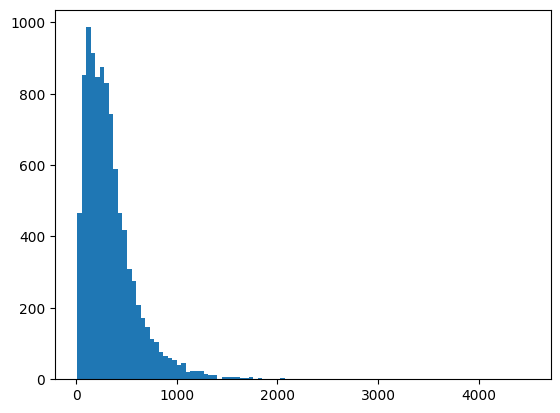

In [65]:
# plot histogram of sample lengths
import matplotlib.pyplot as plt

plt.hist(oa_dataset['len'], bins=100)
plt.show()


## 4. Batching

After tokenization, the data can be batched for training. 

However it is important that all samples in a batch have the same length. This is necessary for model input data handling, by creating an input tensor object.

Follow techniques can help ensure same lenghts within a batch.
* Padding
* Truncation



#### Padding

In padding we add `padding_token` at the end of the shorter sequence to make all batches the same length.

But we don't want the model to attend to the `padding_token` in the attention layer. So we mask the `padding_token` with `0` in the `attention_mask`.

Padding strategies:
* longest
* max_length

In [67]:
samples = [
    "This is the first sample.",
    "This is the second sample slightly longer.",
]

# raw tokenization
tokenizer(samples)['input_ids']

[[2, 1596, 603, 573, 1370, 6453, 235265],
 [2, 1596, 603, 573, 2257, 6453, 9677, 5543, 235265]]

padding can be `left` or `right`

In [80]:
# tokenizer padding size
tokenizer.padding_side

'left'

In [83]:
# tokens with padding and attention mask
tks = tokenizer(samples, padding=True)
print(tks['input_ids'])

print(tks['attention_mask'])

[[0, 0, 2, 1596, 603, 573, 1370, 6453, 235265], [2, 1596, 603, 573, 2257, 6453, 9677, 5543, 235265]]
[[0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [91]:
tks = tokenizer(samples, padding="longest")
print(tks['input_ids'])

tks = tokenizer(samples, padding="max_length") # -> truncate to model max length and pad.
print(tks['input_ids'])

tks = tokenizer(samples, padding="max_length", max_length=20)
print(tks['input_ids'])

[[0, 0, 2, 1596, 603, 573, 1370, 6453, 235265], [2, 1596, 603, 573, 2257, 6453, 9677, 5543, 235265]]
[[2, 1596, 603, 573, 1370, 6453, 235265], [2, 1596, 603, 573, 2257, 6453, 9677, 5543, 235265]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1596, 603, 573, 1370, 6453, 235265], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1596, 603, 573, 2257, 6453, 9677, 5543, 235265]]


### Truncation

Truncation is useful to prevent overflow of input beyond the model's max length.


In [100]:
print(tokenizer.model_max_length)  
print(model.config.max_position_embeddings)     # -> actual model max length
print(tokenizer.truncation_side)

1000000000000000019884624838656
8192
right


In [95]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
model_inputs = tokenizer(sequences, truncation=True)
print(model_inputs['input_ids'])

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=, truncation=True)
print(model_inputs['input_ids'])

[[2, 235285, 235303, 524, 1125, 9316, 604, 476, 25660, 3360, 21929, 3205, 970, 3733, 1913, 235265], [2, 2339, 791, 590, 235341]]
[[2, 235285, 235303, 524, 1125, 9316, 604, 476], [2, 2339, 791, 590, 235341]]


In [96]:
# truncate and pad
model_inputs = tokenizer(sequences, max_length=8, truncation=True, padding=True)
print(model_inputs['input_ids'])

[[2, 235285, 235303, 524, 1125, 9316, 604, 476], [0, 0, 0, 2, 2339, 791, 590, 235341]]


### Batching with Padding and Truncation

* Padding is not performed on entire dataset upto max length of the dataset. Instead it is performed on batches of samples upto max length in the batch. This help save compuation, memory and speed up things. This is called `dynamic batching`.
* During batching, its recommened to batch samples with similar length together, as this will save computational resources and memory.

In [55]:
# example of dynamic padding
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

oa_dataset = load_dataset("timdettmers/openassistant-guanaco", split='train')

def tokenize_oa_sample(example):
    text_col = 'text'
    return tokenizer(example[text_col], truncation=True)

tokenized_oa_dataset = oa_dataset.map(tokenize_oa_sample, batched=True)
tokenized_oa_dataset.remove_columns(['text'])

data_collator = DataCollatorWithPadding(tokenizer)
train_dataloader = DataLoader(
    tokenized_oa_dataset, shuffle=True, batch_size=8, collate_fn=data_collator
)



Repo card metadata block was not found. Setting CardData to empty.


##### Dummy dataset test

In [ ]:
from datasets import Dataset

dummy_dataset = {
    "text": [
        "This is test 1.",
        "This is test 2. Much longer seq.",
        "This is test 3. Much longer seq. Much longer seq. Much longer seq.",
        "This is test 4. Short and sweet."
    ]
}

dummy_dataset = Dataset.from_dict(dummy_dataset)
dummy_dataset

Dataset({
    features: ['text'],
    num_rows: 4
})

In [ ]:
def dummy_tokenize_function(example):
    input_text = example["text"]
    # tokenize the text
    return tokenizer(
        input_text,
        # text_target=input_text,     # input is same as output. left shifting of labels is done by the transformers model
        truncation=True,
        max_length=10,
        padding=True,         
        # return_tensors="pt",
    )

tokenized_dummy_dataset = dummy_dataset.map(dummy_tokenize_function, batched=True, remove_columns=["text"])
tokenized_dummy_dataset

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 4
})

In [ ]:
tokenized_dummy_dataset[:4]

{'input_ids': [[0, 0, 0, 2, 1596, 603, 2121, 235248, 235274, 235265],
  [2, 1596, 603, 2121, 235248, 235284, 235265, 19154, 5543, 28410],
  [2, 1596, 603, 2121, 235248, 235304, 235265, 19154, 5543, 28410],
  [2, 1596, 603, 2121, 235248, 235310, 235265, 13406, 578, 7786]],
 'attention_mask': [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
from transformers import DataCollatorForLanguageModeling

# dummy_datacollator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
dummy_datacollator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

samples = tokenized_dummy_dataset[:4]
samples = [samples]
dc_output = dummy_datacollator(samples)
dc_output

{'input_ids': tensor([[[     0,      0,      0,      2,   1596,    603,   2121, 235248,
          235274, 235265],
         [     2,   1596,    603,   2121, 235248, 235284, 235265,  19154,
            5543,  28410],
         [     2,   1596,    603,   2121, 235248, 235304, 235265,  19154,
            5543,  28410],
         [     2,   1596,    603,   2121, 235248, 235310, 235265,  13406,
             578,   7786]]]), 'attention_mask': tensor([[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]), 'labels': tensor([[[  -100,   -100,   -100,      2,   1596,    603,   2121, 235248,
          235274, 235265],
         [     2,   1596,    603,   2121, 235248, 235284, 235265,  19154,
            5543,  28410],
         [     2,   1596,    603,   2121, 235248, 235304, 235265,  19154,
            5543,  28410],
         [     2,   1596,    603,   2121, 235248, 235310, 235265,  13406,
       

# Alpaca Dataset Prep

Download Alpaca dataset:

In [ ]:
!wget https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json

--2024-03-27 14:46:40--  https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43379276 (41M) [text/plain]
Saving to: ‘alpaca_gpt4_data.json’

alpaca_gpt4_data.js 100%[===================>]  41.37M  44.1MB/s    in 0.9s    

2024-03-27 14:46:42 (44.1 MB/s) - ‘alpaca_gpt4_data.json’ saved [43379276/43379276]



In [1]:
import json

dataset_file = "alpaca_gpt4_data.json"

with open(dataset_file, "r") as f:
    alpaca = json.load(f)

In [2]:
type(alpaca), alpaca[0:3], len(alpaca)


(list,
 [{'instruction': 'Give three tips for staying healthy.',
   'input': '',
   'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'},
  {'instruction': 'What are the three primary colors?',
   'input': '',
   'output': 'The three primary colors are red, blue, and yellow. These

### Train Test split

In [3]:
import random

seed = 42

random.seed(seed)
random.shuffle(alpaca)  # this could also be a parameter

In [4]:
train_dataset = alpaca[:-1000]
eval_dataset = alpaca[-1000:]

Upload dataset to WandB

In [5]:
import pandas as pd
import wandb

train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

train_table = wandb.Table(dataframe=train_df)
eval_table  = wandb.Table(dataframe=eval_df)

train_df.to_json("alpaca_gpt4_train.jsonl", orient='records', lines=True)
eval_df.to_json("alpaca_gpt4_eval.jsonl", orient='records', lines=True)

with wandb.init(project="alpaca_ft", job_type="split_data"):
    at = wandb.Artifact(
        name="alpaca_gpt4_splitted", 
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
    at.add_file("alpaca_gpt4_train.jsonl")
    at.add_file("alpaca_gpt4_eval.jsonl")
    wandb.log_artifact(at)
    wandb.log({"train_dataset":train_table, "eval_dataset":eval_table})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vijaygkd. Use `wandb login --relogin` to force relogin


### Dataset with prompts

In [6]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Response:\n").format_map(row)


def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n").format_map(row)


def create_alpaca_prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)

In [7]:
def pad_eos(ds):
    EOS_TOKEN = "</s>"
    return [f"{row['output']}{EOS_TOKEN}" for row in ds]

Prompts and outputs for dataset

In [8]:
train_prompts = [create_alpaca_prompt(row) for row in train_dataset]
eval_prompts = [create_alpaca_prompt(row) for row in eval_dataset]

In [9]:
train_outputs = pad_eos(train_dataset)
eval_outputs = pad_eos(eval_dataset)

In [11]:
train_prompts[0], train_outputs[0]

('Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe an example of a time you used influence in a positive way\n\n### Response:\n',
 'As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills and

Combine prompts and outputs into dataset

In [12]:
train_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(train_prompts, train_outputs)]
eval_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(eval_prompts, eval_outputs)]

In [13]:
print(train_dataset[0]["example"])


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe an example of a time you used influence in a positive way

### Response:
As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills and experiences.

### Upload processed dataset with prompts to wandb

In [15]:
import pandas as pd
import wandb

train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

train_table = wandb.Table(dataframe=train_df)
eval_table  = wandb.Table(dataframe=eval_df)

train_df.to_json("alpaca_with_prompt_gpt4_train.jsonl", orient='records', lines=True)
eval_df.to_json("alpaca_with_prompt_gpt4_eval.jsonl", orient='records', lines=True)

with wandb.init(project="alpaca_ft", job_type="split_data"):
    at = wandb.Artifact(
        name="alpaca_with_prompt_gpt4_splitted", 
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
    at.add_file("alpaca_with_prompt_gpt4_train.jsonl")
    at.add_file("alpaca_with_prompt_gpt4_eval.jsonl")
    wandb.log_artifact(at)
    wandb.log({"train_dataset":train_table, "eval_dataset":eval_table})
